In [50]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def partial_spearman_corr(df, x, y, controls):
    """Compute partial Spearman correlation between x and y given selected control variables."""
    from statsmodels.api import OLS, add_constant
    
    if controls:
        # Regress x and y on control variables
        residual_x = OLS(df[x], add_constant(df[controls])).fit().resid
        residual_y = OLS(df[y], add_constant(df[controls])).fit().resid
        return spearmanr(residual_x, residual_y)[0]
    else:
        return spearmanr(df[x], df[y])[0]

def plot_causal_graph(adj_matrix, df, ci_test):
    """
    Plots causal graph with edge color based on partial Spearman correlation signs.
    Uses only relevant control variables.
    """
    nodes = df.columns
    G = nx.DiGraph()
    edge_info = []

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                cause = nodes[i]
                effect = nodes[j]
                
                # Identify control variables (parents of cause or effect)
                related_vars = [nodes[k] for k in range(len(nodes)) if adj_matrix[k, j] or adj_matrix[k, i]]
                controls = [var for var in related_vars if var not in [cause, effect]]

                # Compute partial Spearman correlation
                pcorr = partial_spearman_corr(df, cause, effect, controls)

                # Determine edge color and width
                edge_color = 'red' if pcorr > 0 else 'blue'
                edge_width = 1 + 3 * abs(pcorr)

                G.add_edge(cause, effect, weight=pcorr)
                edge_info.append((cause, effect, edge_color, edge_width))

    # Layout & Plot
    pos = nx.circular_layout(G)
    label_pos = {n: (p[0] * 1.3, p[1] * 1.3) for n, p in pos.items()}

    plt.figure(figsize=(10, 10))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', edgecolors='black', node_size=500, alpha=0.9)
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold', font_color='black')

    # Draw edges
    arc_rad = 0.1
    for u, v, color, width in edge_info:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                               arrowstyle='->', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
                               min_source_margin=10, min_target_margin=10)

    plt.title(f"Causal Graph ({ci_test})", fontsize=14)
    plt.gca().margins(x=0.3, y=0.3)
    plt.axis('equal')
    plt.show()

In [88]:
import numpy as np
import pandas as pd
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]
    sami_col = df_select.columns[df_select.columns.str.contains("SAMI", case=False)][0]

    dfp = df_select.pivot(index=["cbsacode",'Year'], columns="factor", values=sami_col).reset_index()
    df_cleaned = dfp.drop(columns=["cbsacode",'Year'])  # Reverse column order as in original code
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(variant='stable', alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=df_cleaned.columns)
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, df_cleaned,ci_test)
    
    return pc

In [195]:
import pandas as pd

# SSAMI


In [142]:
df = pd.read_csv('../00_data/03_analysis_data/ssami_result_0403.csv')

In [143]:
df['factor'].unique()

array(['excessive_drinking', 'no_time_activity', 'some_college',
       'unemployment', 'children_single_parent',
       'mental_health_providers', 'median_household_income',
       'driving_alone_to_work', 'sti', 'gdp', 'Park_Area_Acres',
       'Weighted_RESP', 'noise70n', 'noise80n', 'noise90n', 'smo_obe_dia',
       'smo_obe', 'smo_dia', 'obe_dia', 'depressed'], dtype=object)

In [144]:
my_factors = ['depressed',
    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'smo_obe_dia',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
    'no_time_activity', 

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'gdp', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'mental_health_providers', 

    # social association
    # 'children_single_parent',


    # enviroment
    # 'driving_alone_to_work', 
    # 'Park_Area_Acres',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    'noise90n', 
    
]

ci_test is now: spearman
Learned skeleton (CPDAG):


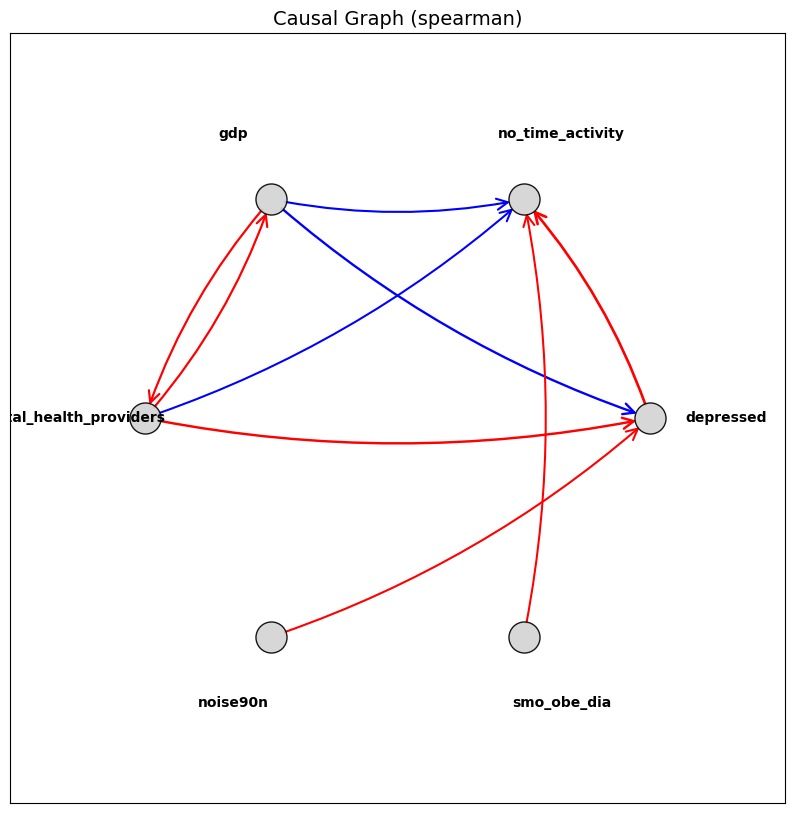

In [146]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='spearman')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


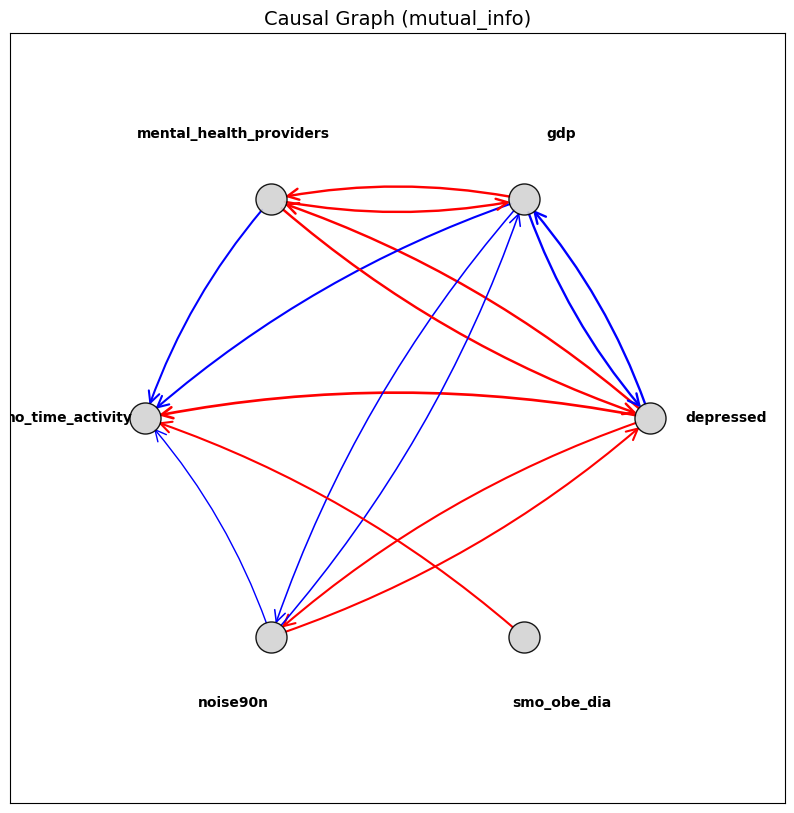

In [147]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

# SAMI

In [148]:
df = pd.read_csv('../00_data/03_analysis_data/sasami_result_0403.csv')

ci_test is now: spearman
Learned skeleton (CPDAG):


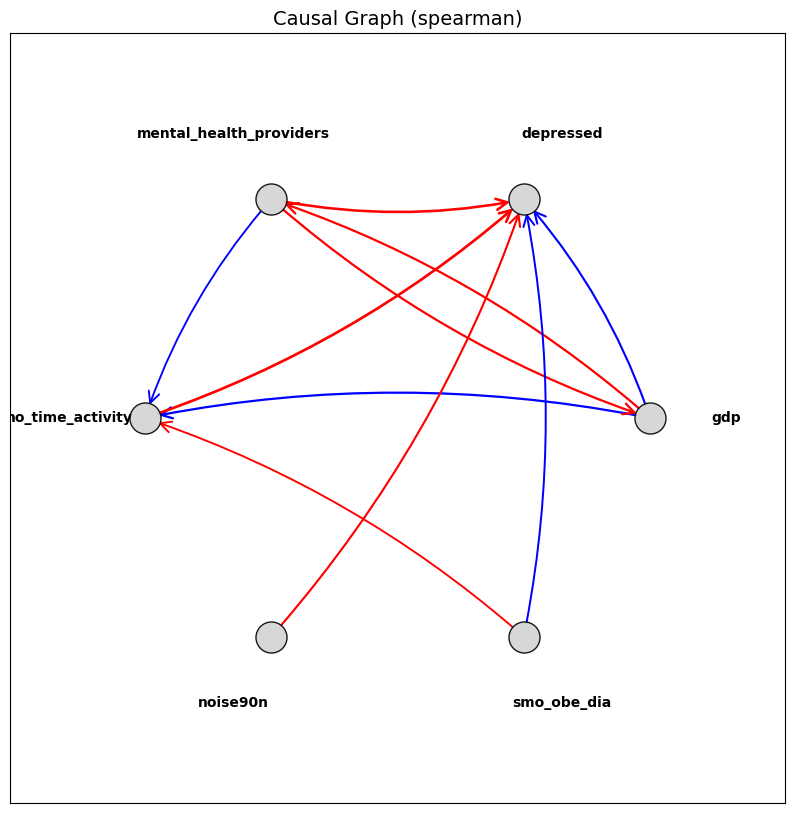

In [149]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='spearman')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


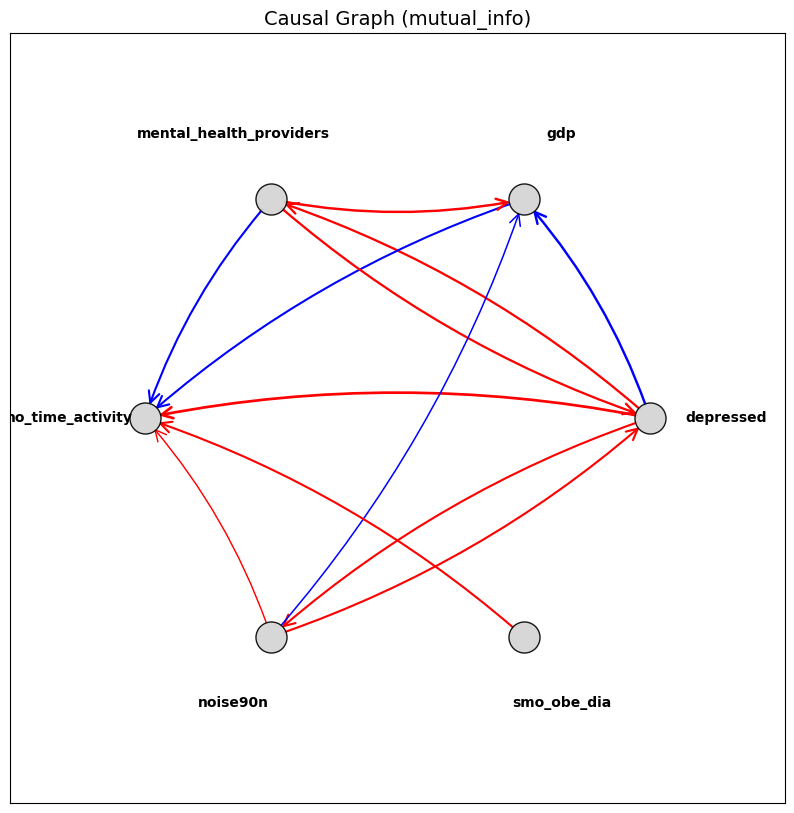

In [150]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

# Density

In [129]:
df = pd.read_csv('../00_data/03_analysis_data/sami_result_0403.csv')

ci_test is now: spearman
Learned skeleton (CPDAG):


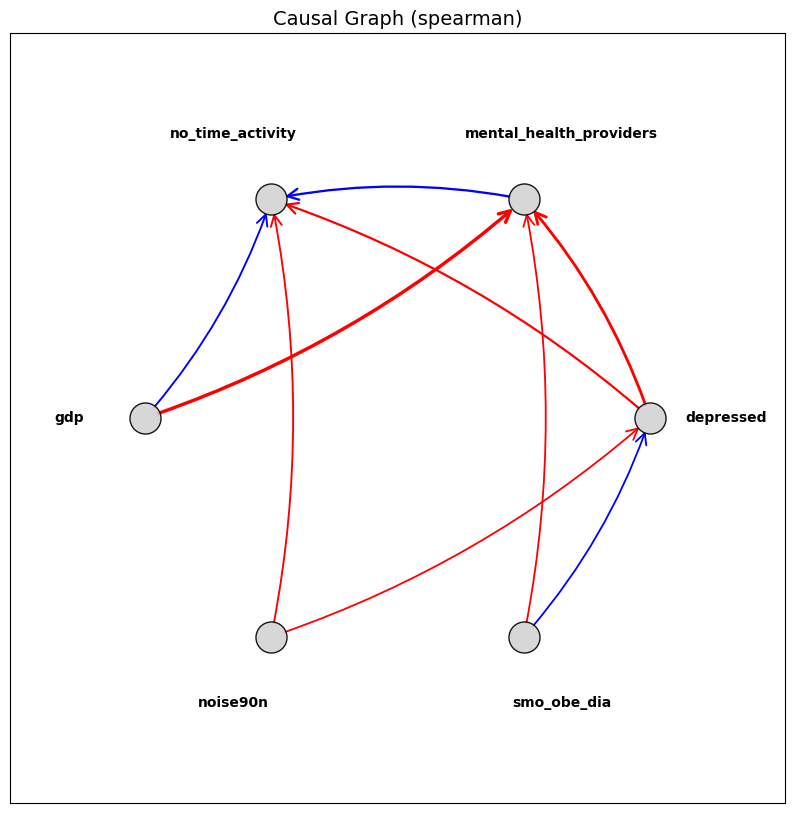

In [130]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='spearman')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


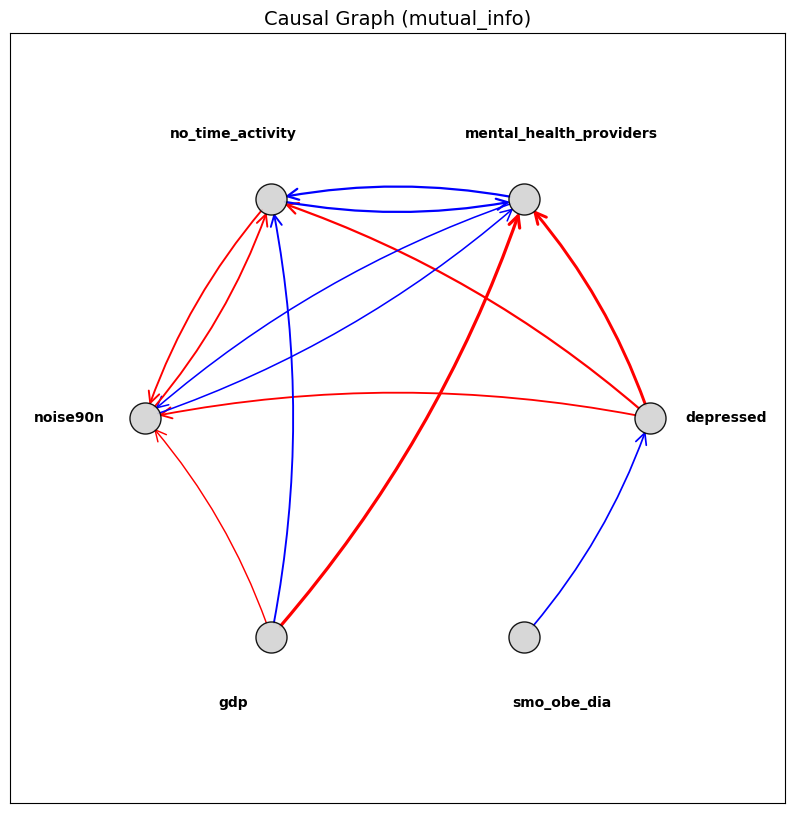

In [131]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

---

In [159]:
df = pd.read_csv('../00_data/03_analysis_data/all_factor_72_12.csv')

In [156]:
df

,Year,cbsacode,Sample_Size,population,adult_smoking,adult_obesity,excessive_drinking,diabetes_prevalence,no_time_activity,some_college,...,noise70n,noise80n,noise90n,smo_obe_dia,smo_obe,smo_dia,obe_dia,depressed,log_population,log_dataval_population
0,2011,10740,2880,857903.0,123687.787094,1.357007e+05,85547.993919,38302.509293,117481.0,143682.0,...,5540.745134,1224.879163,17.445337,-0.834472,-0.653402,-0.650231,-0.739975,186851.2734,13.662246,12.138068
1,2011,11260,482,374553.0,58399.185228,7.407142e+04,49694.181724,18560.182330,58051.0,70584.0,...,0.000000,0.000000,0.000000,-1.062247,-0.867516,-0.853160,-0.881160,65696.5962,12.833489,11.092802
2,2011,12060,15892,5503952.0,688901.435410,1.063977e+06,605445.249041,382898.985792,848352.0,1066375.0,...,38628.932617,8411.143736,261.181207,2.003696,1.688192,1.678403,1.542099,740281.5440,15.520977,13.514786
3,2011,12260,1442,547067.0,88740.928716,1.282184e+05,56390.564574,46079.670066,108477.0,78056.0,...,1531.976762,40.122342,4.028891,-0.881270,-0.736481,-0.698454,-0.723619,85397.1587,13.212327,11.355068
4,2011,12420,1205,1705075.0,227276.255641,3.056785e+05,258215.965344,89557.563452,239279.0,374121.0,...,22763.419503,4618.338378,191.106168,-0.346458,-0.224436,-0.262635,-0.361099,268719.8200,14.349120,12.501425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,2022,45820,1345,230878.0,30858.951001,6.751237e+04,32694.785366,18218.266001,40349.0,36382.0,...,1540.361169,109.303096,9.307088,-1.117193,-0.933806,-0.912468,-0.890394,51901.3744,12.349645,10.857101
860,2022,46140,2331,1006411.0,142723.974003,2.745027e+05,108317.909984,81929.391002,195032.0,164229.0,...,7864.949017,620.703682,47.292402,-0.544005,-0.441602,-0.466376,-0.424753,291557.2667,13.821901,12.582992
861,2022,47260,8550,1760740.0,235602.113995,4.751754e+05,257462.399611,148211.222997,298008.0,351364.0,...,1070.215714,107.331962,17.094573,-0.002970,0.002682,-0.051933,0.041543,400216.2020,14.381245,12.899760
862,2022,48620,1516,643768.0,82246.350996,1.816031e+05,81941.549291,51666.979998,114980.0,113437.0,...,5302.334212,361.131273,60.846898,-0.823419,-0.684208,-0.693779,-0.639230,132873.7152,13.375094,11.797154


In [168]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def scaling(X, y, ci_vars=None):
    """
    Perform OLS regression of y on X (with intercept). Returns coefficients, 
    confidence intervals, R-squared, and number of observations.

    Parameters:
    - X: DataFrame or Series of predictor(s)
    - y: Series of response variable
    - ci_vars: List of variable names (str) for which to extract 95% CI 
               If None, return CI for all predictors

    Returns:
    - betas: Dictionary of coefficients {var_name: beta}
    - cis: Dictionary of 95% CIs {var_name: (lower, upper)}
    - r_squared: R-squared of the regression
    - n: Number of observations
    """
    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    betas = model.params.to_dict()
    conf_int = model.conf_int(alpha=0.05)

    if ci_vars is None:
        ci_vars = X.columns.tolist()
    
    cis = {var: tuple(conf_int.loc[var]) for var in ci_vars if var in conf_int.index}

    return betas, cis, model.rsquared, len(y)

In [177]:
predictor_vars = ['log_population']  # <-- your predictors here

# Initialize results dict
table_results = {
    'Dataset': [],
    'R^2': [],
    'n': []
}

# Add keys dynamically based on predictors
for var in predictor_vars:
    table_results[f'β ({var})'] = []
    table_results[f'95% CI ({var})'] = []

# Regression loop
for year in sorted(df['Year'].unique()):
    subset = df[df['Year'] == year]
    if len(subset) > 1:
        X = subset[predictor_vars]
        y = subset['log_depressed']

        betas, cis, r2, n = scaling(X, y, ci_vars=predictor_vars)

        table_results['Dataset'].append(f'BRFSS{int(year)}')
        table_results['R^2'].append(r2)
        table_results['n'].append(n)

        for var in predictor_vars:
            table_results[f'β ({var})'].append(betas.get(var, np.nan))
            table_results[f'95% CI ({var})'].append(cis.get(var, (np.nan, np.nan)))

# Final result
results_df1 = pd.DataFrame(table_results)
results_df1

,Dataset,R^2,n,β (log_population),95% CI (log_population)
0,BRFSS2011,0.981693,72,0.922117,"(0.8920994729458828, 0.952134232123769)"
1,BRFSS2012,0.983064,72,0.926068,"(0.8970933925365837, 0.9550435203036048)"
2,BRFSS2013,0.977640,72,0.945144,"(0.9110710437541988, 0.9792175711036627)"
3,BRFSS2014,0.979137,72,0.935227,"(0.9026846146578078, 0.9677698288011716)"
4,BRFSS2015,0.980899,72,0.922760,"(0.8920639767203964, 0.9534555815592065)"
5,BRFSS2016,0.973736,72,0.928876,"(0.8925103885656143, 0.9652418548607204)"
6,BRFSS2017,0.986920,72,0.933087,"(0.9074806324844732, 0.9586936253410395)"
7,BRFSS2018,0.973941,72,0.940454,"(0.9037832604459135, 0.9771253279706564)"
8,BRFSS2019,0.974969,72,0.919317,"(0.884203218051489, 0.9544307122625723)"
9,BRFSS2020,0.982749,72,0.933378,"(0.9038992276997304, 0.9628569849212372)"


In [ ]:
predictor_vars = ['log_population', 'log_noise'] 

# Initialize results dict
table_results = {
    'Dataset': [],
    'R^2': [],
    'n': []
}

# Add keys dynamically based on predictors
for var in predictor_vars:
    table_results[f'β ({var})'] = []
    table_results[f'95% CI ({var})'] = []

# Regression loop
for year in sorted(df['Year'].unique()):
    subset = df[df['Year'] == year]
    if len(subset) > 1:
        X = subset[predictor_vars]
        y = subset['log_depressed']

        betas, cis, r2, n = scaling(X, y, ci_vars=predictor_vars)

        table_results['Dataset'].append(f'BRFSS{int(year)}')
        table_results['R^2'].append(r2)
        table_results['n'].append(n)

        for var in predictor_vars:
            table_results[f'β ({var})'].append(betas.get(var, np.nan))
            table_results[f'95% CI ({var})'].append(cis.get(var, (np.nan, np.nan)))

# Final result
results_df2 = pd.DataFrame(table_results)
results_df2

,Dataset,R^2,n,β (log_population),95% CI (log_population),β (log_noise),95% CI (log_noise)
0,BRFSS2011,0.981729,72,0.919497,"(0.8860863819912096, 0.9529082967769019)",0.001778,"(-0.007906047198588432, 0.011462687871279445)"
1,BRFSS2012,0.983408,72,0.917889,"(0.8859368232612832, 0.9498421245815523)",0.005553,"(-0.0037091669521407186, 0.014814170111786073)"
2,BRFSS2013,0.978782,72,0.929916,"(0.8929453675207656, 0.9668857954594187)",0.010300,"(-0.0003632881853230692, 0.02096424446388447)"
3,BRFSS2014,0.979951,72,0.922526,"(0.8869995621723653, 0.9580518753982908)",0.008599,"(-0.0016490905499886802, 0.01884729716312588)"
4,BRFSS2015,0.981517,72,0.911841,"(0.8782129729093664, 0.9454693852196954)",0.007385,"(-0.002309937003696281, 0.017080699494832072)"
5,BRFSS2016,0.973750,72,0.930569,"(0.8900736636816177, 0.9710650924749574)",-0.001145,"(-0.01282886062357688, 0.01053811506865751)"
6,BRFSS2017,0.987200,72,0.925672,"(0.8974477690730303, 0.9538952838449914)",0.005014,"(-0.0031350819713962773, 0.013162329940485048)"
7,BRFSS2018,0.974019,72,0.944427,"(0.9036260241852434, 0.9852289477865999)",-0.002685,"(-0.014463236545961272, 0.009094049560985534)"
8,BRFSS2019,0.975066,72,0.914978,"(0.8759065171176187, 0.9540503706940159)",0.002930,"(-0.008369624814969983, 0.014229337203894781)"
9,BRFSS2020,0.982851,72,0.928870,"(0.8960754767157959, 0.961664576726539)",0.003033,"(-0.006447661803996111, 0.012512788837353876)"


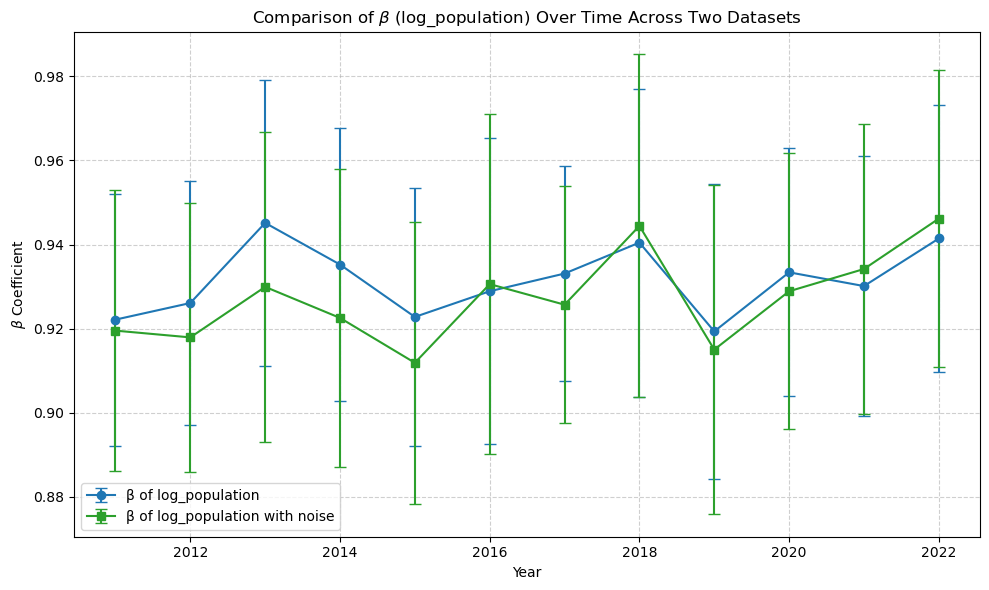

In [181]:
import matplotlib.pyplot as plt

# Extract years
results_df1['Year'] = results_df1['Dataset'].str.extract(r'(\d+)').astype(int)
results_df2['Year'] = results_df2['Dataset'].str.extract(r'(\d+)').astype(int)

# Sort by Year
results_df1 = results_df1.sort_values('Year')
results_df2 = results_df2.sort_values('Year')

# Set up figure
plt.figure(figsize=(10, 6))

# Function to plot one dataset
def plot_beta_with_ci(df, label, color, marker):
    years = df['Year']
    beta = df['β (log_population)']
    ci_bounds = df['95% CI (log_population)']
    ci_lower = ci_bounds.apply(lambda x: x[0])
    ci_upper = ci_bounds.apply(lambda x: x[1])
    lower_err = beta - ci_lower
    upper_err = ci_upper - beta
    plt.errorbar(
        years, beta,
        yerr=[lower_err, upper_err],
        fmt=marker + '-',
        capsize=4,
        label=label,
        color=color
    )

# Plot both datasets
plot_beta_with_ci(results_df1, label='β of log_population', color='tab:blue', marker='o')
plot_beta_with_ci(results_df2, label='β of log_population with noise', color='tab:green', marker='s')

# Customize plot
plt.xlabel('Year')
plt.ylabel(r'$\beta$ Coefficient')
plt.title(r'Comparison of $\beta$ (log_population) Over Time Across Two Datasets')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

ci_test is now: spearman
Learned skeleton (CPDAG):


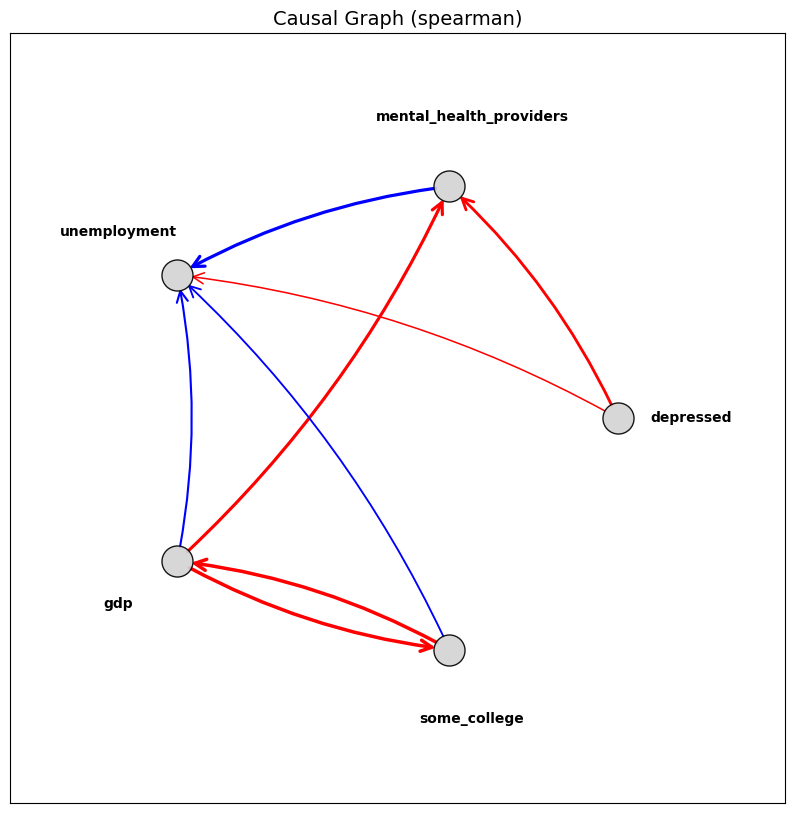

In [76]:
my_factors = [
    'adult_obesity', 
              # 'adult_smoking',
      #  'children_in_single-parent_households', 
       'depressed',
      #  'diabetes_prevalence',
        #  'driving_alone_to_work',
      #  'excessive_drinking', 
       'gdp', 
      #  'low_birthweight',
      #  'median_household_income', 
       'mental_health_providers',
      #  'not_proficient_in_english', 
      # 'poor_or_fair_health',
      #  'primary_care_physicians', 'rural',
      #  'sexually_transmitted_infections',
         'some_college', 
         'unemployment',
      #  'uninsured_adults'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

Learned skeleton (CPDAG):


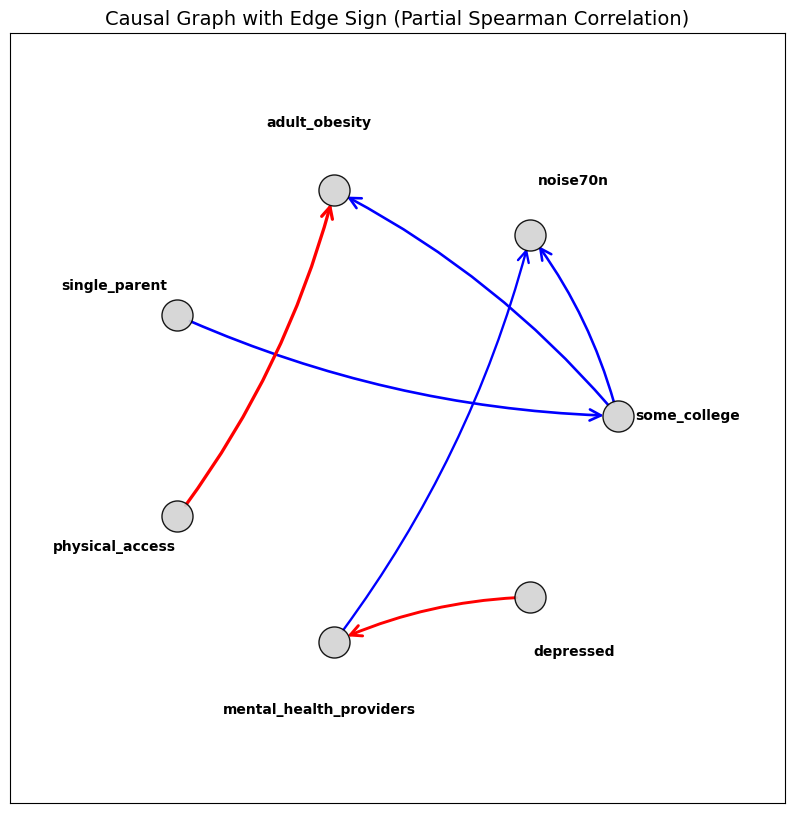

In [163]:
my_factors = [
    'median_household_income','adult_obesity','noise70n',
    'depressed','mental_health_providers','some_college',
    'single_parent','physical_access'#,'suicide'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

In [41]:
df['factor'].unique()

array(['depressed', 'suicide', 'some_college', 'single_parent',
       'driving_alone', 'median_household_income',
       'mental_health_providers', 'social_associations', 'unemployment',
       'noise70n', 'Park_Area_Acres', 'Weighted_RESP',
       'adult_excessive_drinking', 'adult_obesity', 'physical_access',
       'adult_smoking', 'adult_sti', 'adult_diabetes_prevalence',
       'health_pca'], dtype=object)

Learned skeleton (CPDAG):


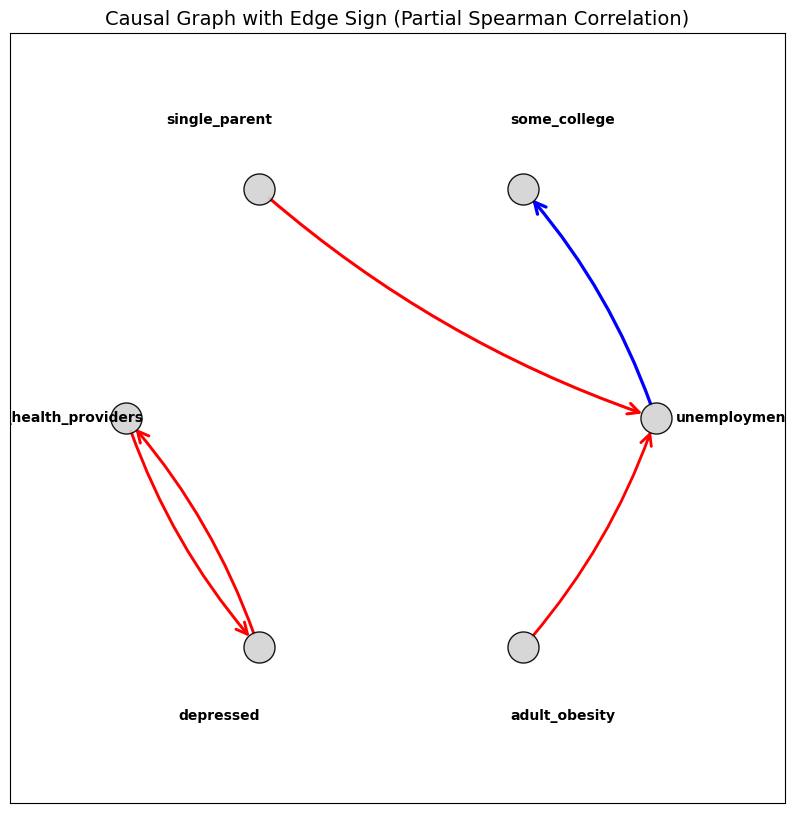

In [184]:
my_factors = ['depressed', 'some_college', 'single_parent',
       'mental_health_providers', 'social_associations', 'unemployment',
       'Park_Area_Acres', 'Weighted_RESP', 'adult_obesity',
       'adult_smoking'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

Learned skeleton (CPDAG):


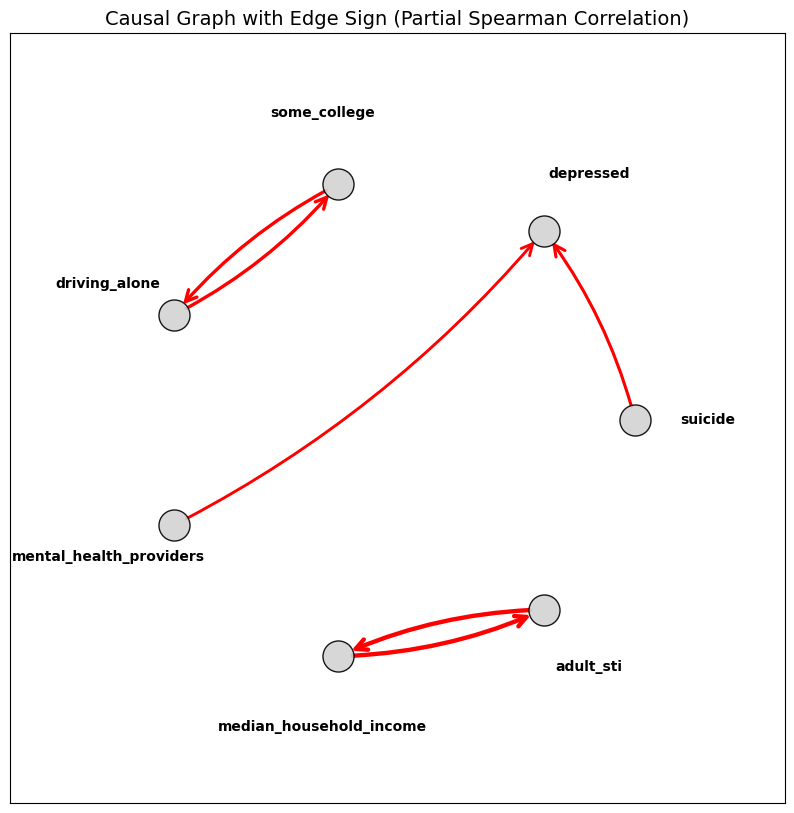

In [167]:
my_factors = ['depressed', 'suicide', 'some_college', 'single_parent',
       'driving_alone', 'median_household_income',
       'mental_health_providers', 
       'noise70n', 'Park_Area_Acres', 'Weighted_RESP', 
       'adult_smoking', 'adult_sti'
       ]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True)

In [241]:
dfp

factor,cbsacode,year,Park_Area_Acres,Weighted_RESP,adult_obesity,adult_smoking,children_eligible_for_free_or_reduced_price_lunch,children_in_poverty,children_in_single_parent_households,depressed,...,poor_physical_health_days,premature_death,preventable_hospital_stays,primary_care_physicians,rural,sexually_transmitted_infections,some_college,unemployment,uninsured_adults,violent_crime
0,10740.0,2011,-0.438079,-0.547852,-0.230028,-0.016582,0.130130,-0.224445,0.189277,-0.188075,...,0.369435,-0.188931,0.025941,0.162565,-0.426485,-0.064472,0.199744,0.122076,0.647431,NaN
1,10740.0,2012,-0.415192,-0.547852,-0.335447,-0.141340,0.245807,-0.139694,0.199380,-0.214462,...,0.365514,-0.184033,0.016127,0.161725,-0.426485,0.016037,0.124675,0.254075,0.452958,0.457532
2,10740.0,2013,-0.456462,-0.549159,-0.340474,-0.081933,0.279182,-0.084522,0.200258,-0.279396,...,0.370129,-0.262118,-0.063308,0.048848,-0.411119,0.151049,0.138128,0.211637,0.425726,0.408250
3,10740.0,2014,-0.453057,-0.548865,-0.312738,-0.029383,0.234171,-0.178664,0.205192,-0.173811,...,0.384453,-0.212762,-0.029388,0.103795,-0.415892,-0.083509,0.141795,0.275926,0.487585,0.419032
4,10740.0,2015,-0.467894,-0.548477,-0.341716,-0.100690,0.273996,-0.051951,0.220825,-0.280372,...,0.382347,-0.306155,0.000614,0.084047,-0.421930,-0.050364,0.087747,0.329508,0.426053,0.394306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,49340.0,2018,-0.194505,-0.180550,-0.318312,0.065484,NaN,-0.414717,0.003279,-0.067214,...,0.002819,-0.010488,0.690992,0.012699,0.114302,-0.319410,0.027401,-0.205341,-1.119941,0.438076
860,49340.0,2019,-0.213661,-0.180567,-0.354920,0.066602,NaN,-0.289368,0.029679,-0.017938,...,0.004721,-0.001488,0.634661,-0.004657,0.105223,-0.232611,-0.000254,-0.128877,-1.028964,0.320264
861,49340.0,2020,-0.240287,-0.180548,-0.362704,-0.052276,NaN,-0.378483,0.013226,-0.074102,...,0.049566,0.048686,0.652360,-0.009856,0.085551,-0.291849,0.032484,-0.143217,-0.985201,0.356601
862,49340.0,2021,-0.249823,-0.180284,-0.335709,0.067210,NaN,-0.203104,-0.016876,-0.024803,...,0.011559,-0.021198,0.625004,0.010086,0.075102,-0.247321,0.068310,-0.207662,-1.007847,0.328471


In [244]:
df_cleaned

factor,cbsacode,year,Park_Area_Acres,Weighted_RESP,adult_obesity,adult_smoking,children_eligible_for_free_or_reduced_price_lunch,children_in_poverty,children_in_single_parent_households,depressed,...,poor_or_fair_health,poor_physical_health_days,premature_death,preventable_hospital_stays,primary_care_physicians,rural,sexually_transmitted_infections,some_college,unemployment,uninsured_adults
0,10740.0,2011,-0.438079,-0.547852,-0.230028,-0.016582,0.130130,-0.224445,0.189277,-0.188075,...,0.009198,0.369435,-0.188931,0.025941,0.162565,-0.426485,-0.064472,0.199744,0.122076,0.647431
1,10740.0,2012,-0.415192,-0.547852,-0.335447,-0.141340,0.245807,-0.139694,0.199380,-0.214462,...,0.013465,0.365514,-0.184033,0.016127,0.161725,-0.426485,0.016037,0.124675,0.254075,0.452958
2,10740.0,2013,-0.456462,-0.549159,-0.340474,-0.081933,0.279182,-0.084522,0.200258,-0.279396,...,-0.037889,0.370129,-0.262118,-0.063308,0.048848,-0.411119,0.151049,0.138128,0.211637,0.425726
3,10740.0,2014,-0.453057,-0.548865,-0.312738,-0.029383,0.234171,-0.178664,0.205192,-0.173811,...,-0.040948,0.384453,-0.212762,-0.029388,0.103795,-0.415892,-0.083509,0.141795,0.275926,0.487585
4,10740.0,2015,-0.467894,-0.548477,-0.341716,-0.100690,0.273996,-0.051951,0.220825,-0.280372,...,-0.051081,0.382347,-0.306155,0.000614,0.084047,-0.421930,-0.050364,0.087747,0.329508,0.426053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,49340.0,2018,-0.194505,-0.180550,-0.318312,0.065484,NaN,-0.414717,0.003279,-0.067214,...,0.052007,0.002819,-0.010488,0.690992,0.012699,0.114302,-0.319410,0.027401,-0.205341,-1.119941
860,49340.0,2019,-0.213661,-0.180567,-0.354920,0.066602,NaN,-0.289368,0.029679,-0.017938,...,0.050458,0.004721,-0.001488,0.634661,-0.004657,0.105223,-0.232611,-0.000254,-0.128877,-1.028964
861,49340.0,2020,-0.240287,-0.180548,-0.362704,-0.052276,NaN,-0.378483,0.013226,-0.074102,...,-0.004642,0.049566,0.048686,0.652360,-0.009856,0.085551,-0.291849,0.032484,-0.143217,-0.985201
862,49340.0,2021,-0.249823,-0.180284,-0.335709,0.067210,NaN,-0.203104,-0.016876,-0.024803,...,-0.029176,0.011559,-0.021198,0.625004,0.010086,0.075102,-0.247321,0.068310,-0.207662,-1.007847


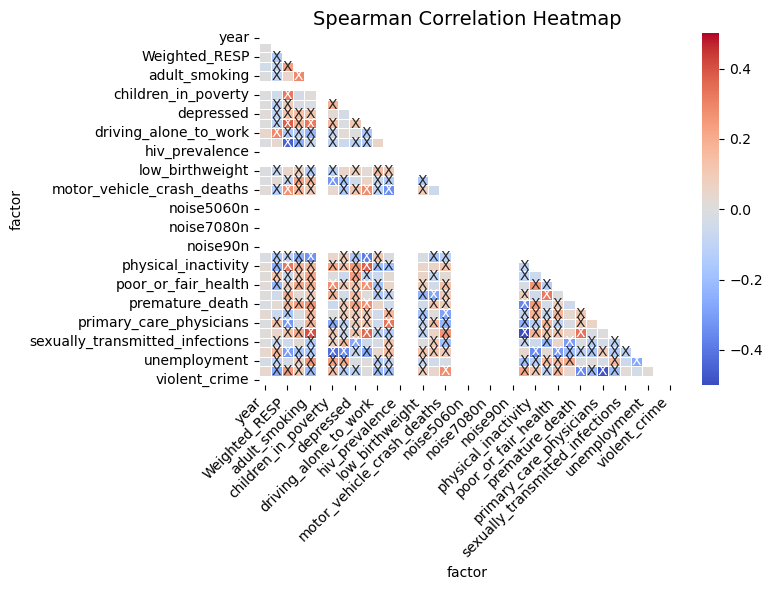

In [245]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the dataframe
dfp = df.pivot(index=["cbsacode",'year'], columns="factor", values="SSAMI_d").reset_index()
df_cleaned = dfp.copy()

# Define factor list (excluding index column if present)
factor_list = df_cleaned.columns.drop('cbsacode', errors='ignore')  

# Initialize correlation and p-value matrices
spearman_corr = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)
p_values = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)

# Compute Spearman correlations
for f1, f2 in itertools.combinations(factor_list, 2):
    corr, p_value = spearmanr(df_cleaned[f1], df_cleaned[f2])
    spearman_corr.loc[f1, f2] = spearman_corr.loc[f2, f1] = corr
    p_values.loc[f1, f2] = p_values.loc[f2, f1] = p_value

# Fill diagonals
np.fill_diagonal(spearman_corr.values, 1)
np.fill_diagonal(p_values.values, 1)

# Create annotation matrix
annot_matrix = np.where(p_values.to_numpy() <= 0.05, 'X', '')

# Mask for upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.astype(float), annot=annot_matrix, mask=mask,
            cmap="coolwarm", vmin=-0.5, vmax=0.5, fmt="", linewidths=0.5, cbar=True)

plt.title("Spearman Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [125]:
df_cleaned

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620


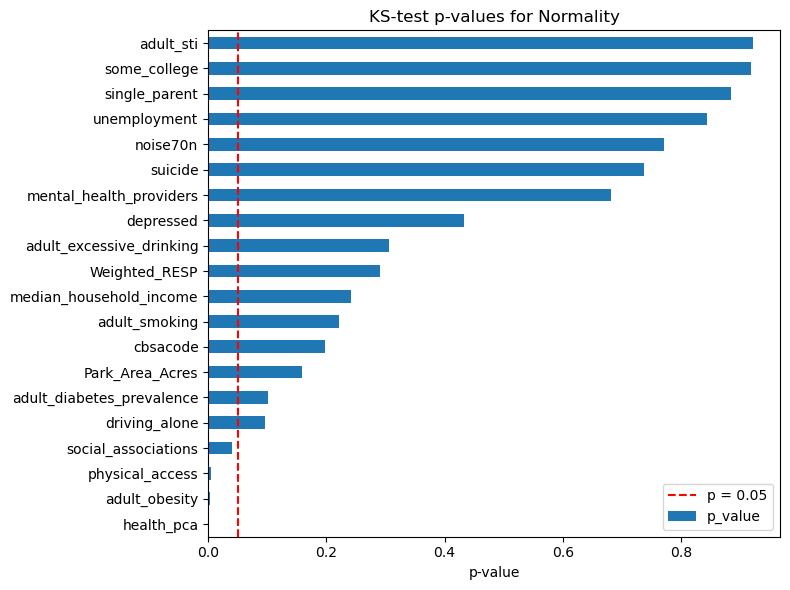

In [126]:
from scipy.stats import kstest, zscore
import pandas as pd

# Assume your data is in a dataframe called df_factors (like in the image)
# Example: df_factors = df.drop(columns="factor") if "factor" is just index

ks_results = {}

# Loop through each column and perform KS test after z-score normalization
for col in df_cleaned.columns:
    data = df_cleaned[col].dropna()  # Drop NaNs if any
    standardized_data = zscore(data)  # Standardize to mean 0, std 1
    stat, p_value = kstest(standardized_data, 'norm')  # Test against N(0,1)
    ks_results[col] = {"KS_statistic": stat, "p_value": p_value}

# Convert to DataFrame for display
ks_df = pd.DataFrame(ks_results).T
ks_df["normal"] = ks_df["p_value"] > 0.05  # True if fails to reject normality

import matplotlib.pyplot as plt

# Optional: plot the p-values
ks_df["p_value"].sort_values().plot(kind="barh", figsize=(8,6))
plt.axvline(x=0.05, color='red', linestyle='--', label='p = 0.05')
plt.title("KS-test p-values for Normality")
plt.xlabel("p-value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_cleaned= df_cleaned.drop

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataframe (replace df_filtered with your actual dataframe name)


# Compute Variance Inflation Factor (VIF)
#X = sm.add_constant(df)  # Add a constant for intercept
vif_data = pd.DataFrame()
vif_data["Feature"] = df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(df_cleaned.values, i) for i in range(df_cleaned.shape[1])]

styled_table = (
    vif_data.style
    .set_caption("Variance Inflation Factor (VIF)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]}
    ])
    .set_properties(**{'text-align': 'center'})
)

# Display the table
styled_table

# per captia

MissingDataError: exog contains inf or nans